# Weather Forecasting Project

This notebook addresses the task of predicting whether it will rain or not based on historical weather data. Farmers need hyper-local and accurate weather predictions for decisions related to irrigation, planting, and harvesting.

In [16]:
import pandas as pd
import numpy as np

# Load the data
df = pd.read_csv('weather_data.csv')

# Inspect the data
print(df.head())
print(df.info())

         date  avg_temperature   humidity  avg_wind_speed rain_or_not  \
0  2023-01-01        23.745401  46.140905        7.845981        Rain   
1  2023-01-02        30.030503  59.876587        5.382457        Rain   
2  2023-01-03        28.365224  51.464618       13.158008        Rain   
3  2023-01-04        27.550929  53.103799        5.886677        Rain   
4  2023-01-05        23.639303  57.826186       12.248992        Rain   

   cloud_cover     pressure  
0    20.851051   992.965681  
1    93.059521  1037.273025  
2    11.636640  1034.193357  
3    81.744971   968.610142  
4    38.062329  1030.264331  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             311 non-null    object 
 1   avg_temperature  296 non-null    float64
 2   humidity         296 non-null    float64
 3   avg_wind_speed   296 non-null    float64
 

### 1. Data Preprocessing

In this section, we handle duplicate entries, missing values, convert data types, and create additional features such as:
- Temporal features (month, day of year, day of week)
- Lagged variables (previous day values)
- Rolling statistics (moving averages and standard deviations)
- Interaction variables

In [17]:
# Count the duplicates
duplicates = df.duplicated().sum()
print("Number of duplicate values:", duplicates)

Number of duplicate values: 0


In [18]:
# Handle the missing values
missing_rows = df.isnull().any(axis=1)

# Count the rows with missing values
print("Number of missing rows:", missing_rows.sum())

# View the rows with missing values
print(df[missing_rows])

Number of missing rows: 15
           date  avg_temperature  humidity  avg_wind_speed rain_or_not  \
12   2023-01-13              NaN       NaN             NaN     No Rain   
15   2023-01-16              NaN       NaN             NaN        Rain   
16   2023-01-17              NaN       NaN             NaN     No Rain   
44   2023-02-14              NaN       NaN             NaN        Rain   
47   2023-02-17              NaN       NaN             NaN        Rain   
52   2023-02-22              NaN       NaN             NaN     No Rain   
57   2023-02-27              NaN       NaN             NaN        Rain   
71   2023-03-13              NaN       NaN             NaN     No Rain   
111  2023-04-22              NaN       NaN             NaN        Rain   
114  2023-04-25              NaN       NaN             NaN        Rain   
125  2023-05-06              NaN       NaN             NaN        Rain   
140  2023-05-21              NaN       NaN             NaN        Rain   
216  2023-0

In [19]:
# Convert the date column to datetime
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
df['day_of_year'] = df['date'].dt.dayofyear
df['day_of_week'] = df['date'].dt.dayofweek

# Drop the date column
df.drop('date', axis=1, inplace=True)

# Connvert rain_or_not to binary
df['rain_or_not'] = df['rain_or_not'].map({'Rain': 1, 'No Rain': 0})

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   avg_temperature  296 non-null    float64
 1   humidity         296 non-null    float64
 2   avg_wind_speed   296 non-null    float64
 3   rain_or_not      311 non-null    int64  
 4   cloud_cover      296 non-null    float64
 5   pressure         311 non-null    float64
 6   month            311 non-null    int32  
 7   day_of_year      311 non-null    int32  
 8   day_of_week      311 non-null    int32  
dtypes: float64(5), int32(3), int64(1)
memory usage: 18.4 KB
None


In [20]:
# Lagged variables
df['avg_temperature_lag1'] = df['avg_temperature'].shift(1).fillna(df['avg_temperature'].iloc[0])
df['avg_wind_speed_lag1'] = df['avg_wind_speed'].shift(1).fillna(df['avg_wind_speed'].iloc[0])
df['humidity_lag1'] = df['humidity'].shift(1).fillna(df['humidity'].iloc[0])
df['cloud_cover_lag1'] = df['cloud_cover'].shift(1).fillna(df['cloud_cover'].iloc[0])
df['pressure_lag1'] = df['pressure'].shift(1).fillna(df['pressure'].iloc[0])
df['rain_or_not_lag1'] = df['rain_or_not'].shift(1).fillna(df['rain_or_not'].iloc[0])

In [21]:
# Rolling variables
df['avg_temperature_roll3'] = df['avg_temperature'].rolling(window=3).mean().fillna(df['avg_temperature'])
df['avg_humidity_roll7'] = df['humidity'].rolling(window=7).std().fillna(df['humidity'])
df['avg_wind_speed_roll3'] = df['avg_wind_speed'].rolling(window=3).mean().fillna(df['avg_wind_speed'])
df['cloud_cover_roll7'] = df['cloud_cover'].rolling(window=7).mean().fillna(df['cloud_cover'])
df['pressure_roll3'] = df['pressure'].rolling(window=3).mean().fillna(df['pressure'])
df['rain_or_not_roll3'] = df['rain_or_not'].rolling(window=3).mean().fillna(df['rain_or_not'])

# Delete missing rows
df = df.dropna()

In [22]:
# Interaction variables
df['temp_wind_interaction'] = df['avg_temperature'] * df['avg_wind_speed']
df['presure_humidity_interaction'] = df['pressure'] * df['humidity']

### 2. Exploratory Data Analysis (EDA)

Here we visualize:
- The class distribution of the target variable (`rain_or_not`)
- The correlation matrix for the key numerical features
- Histograms for feature distributions
- Box plots and scatter plots to inspect the relationship between features and rain occurrence

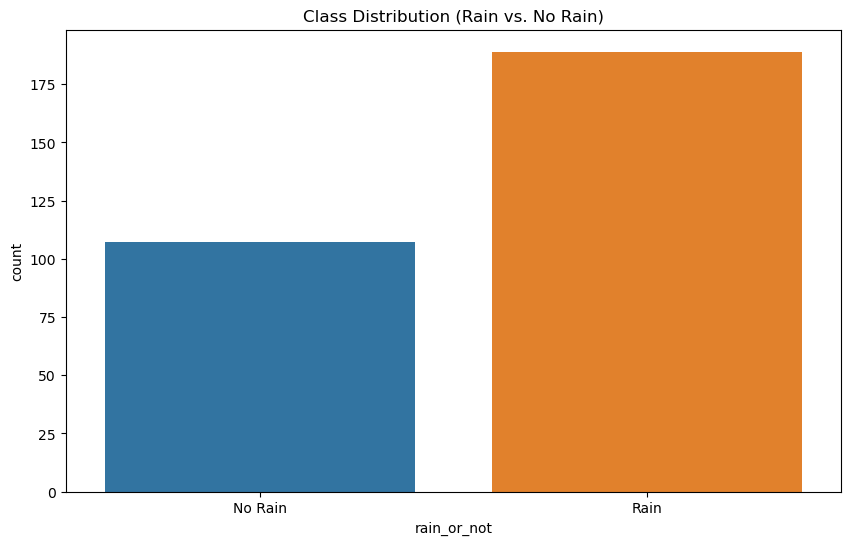

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of the target variable
plt.figure(figsize=(10, 6))
sns.countplot(x='rain_or_not', data=df)
plt.xticks(ticks=[0, 1], labels=['No Rain', 'Rain'])
plt.title('Class Distribution (Rain vs. No Rain)')
plt.show()

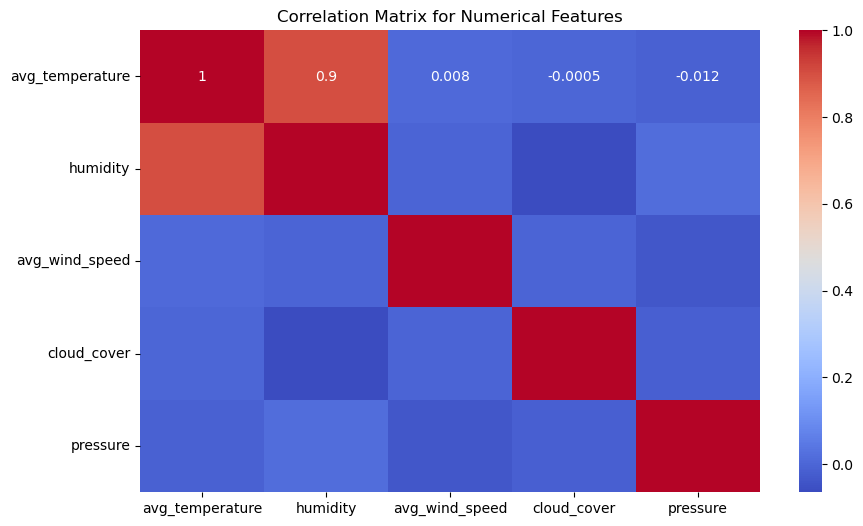

In [24]:
numerical_features = ['avg_temperature', 'humidity', 'avg_wind_speed', 'cloud_cover', 'pressure']

# Plot the distribution of the numerical features
plt.figure(figsize=(10, 6))
sns.heatmap(df[numerical_features].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Numerical Features')
plt.show()

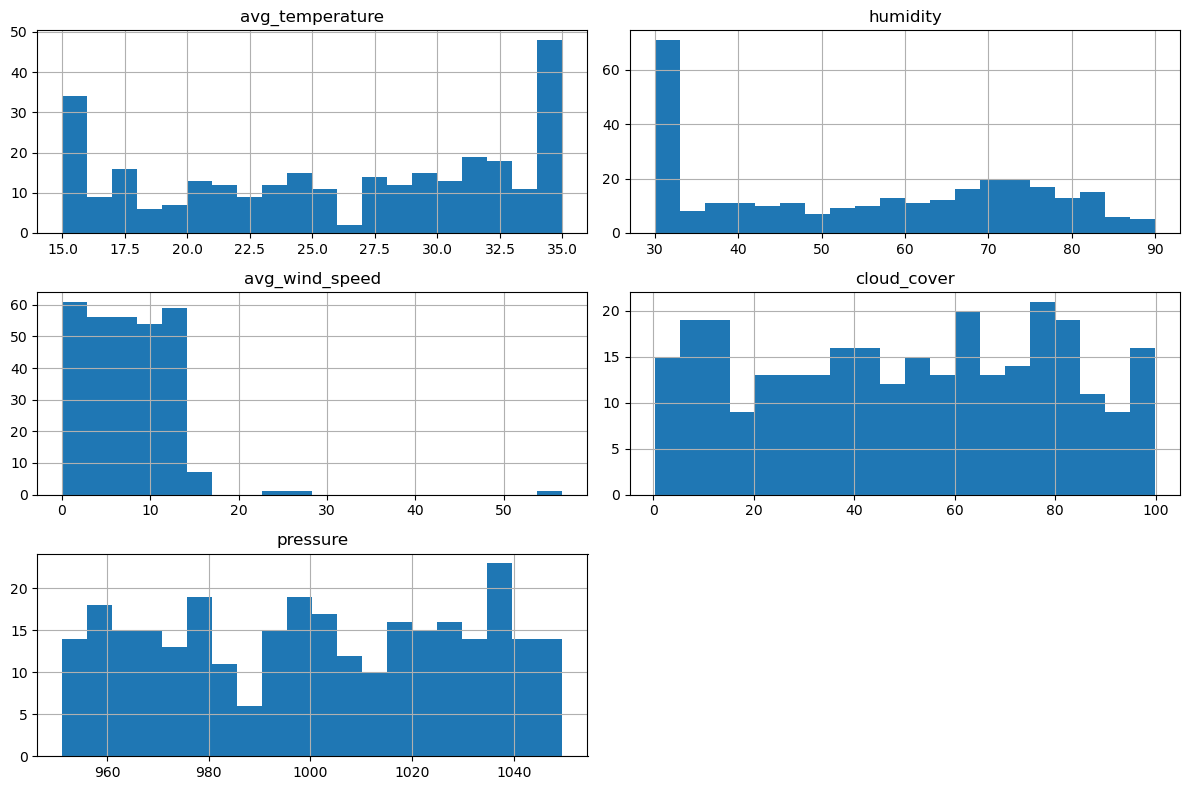

In [25]:
# Histogram of numerical features
df[numerical_features].hist(bins=20, figsize=(12, 8))
plt.tight_layout()
plt.show()

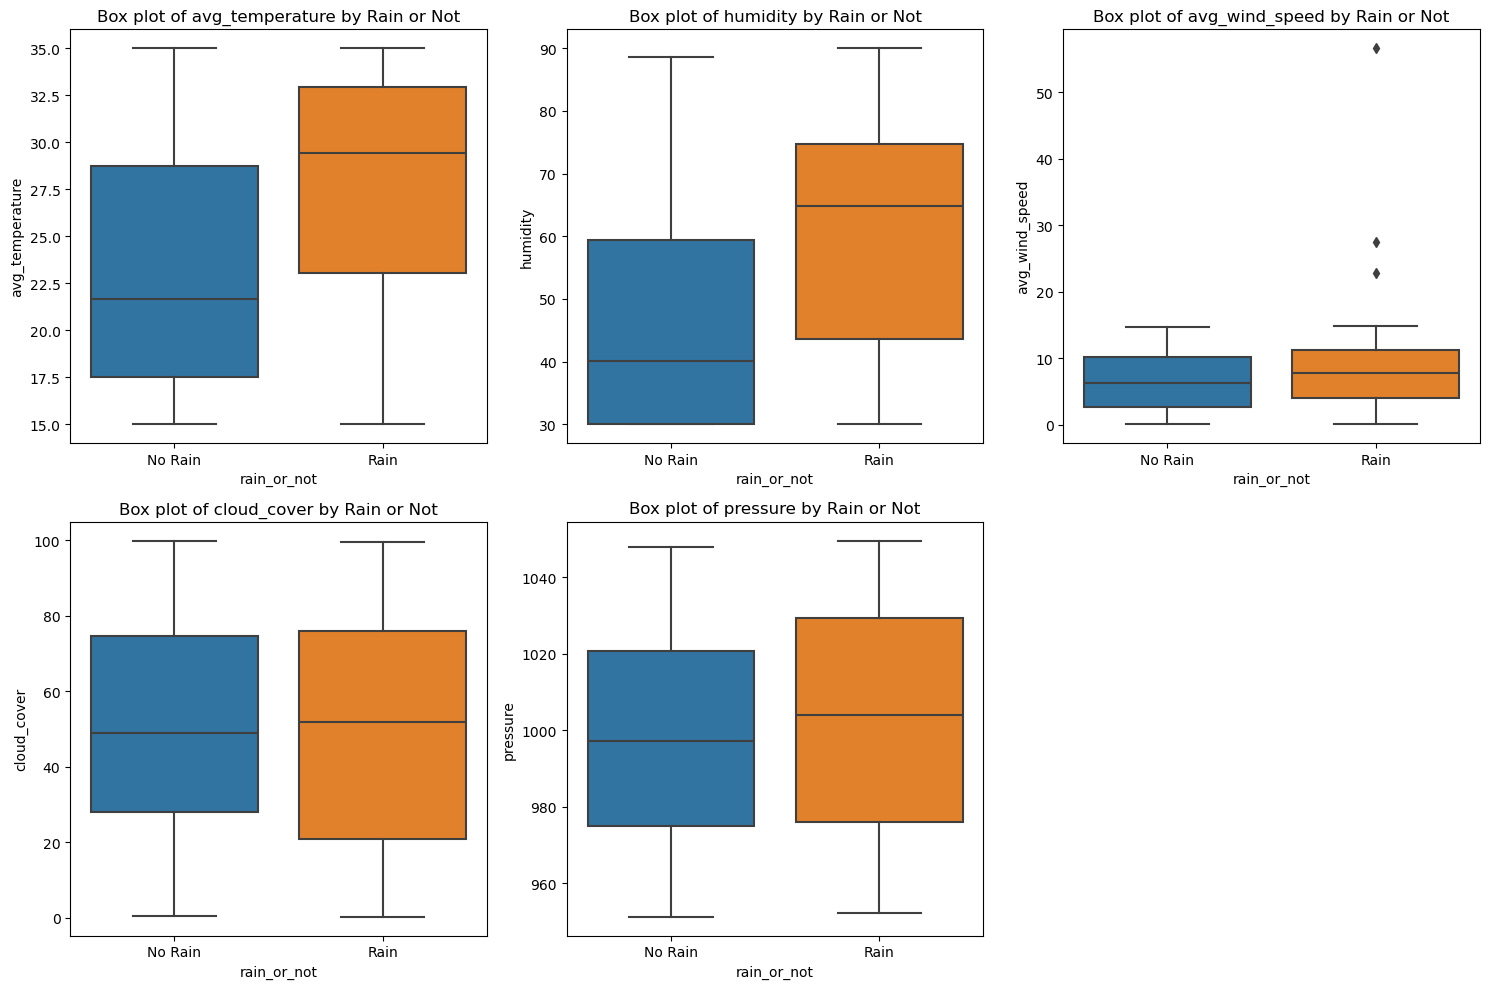

In [26]:
# Box plot of numerical features by rain or not
plt.figure(figsize=(15, 10))

for i, feature in enumerate(numerical_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='rain_or_not', y=feature, data=df)
    plt.xticks(ticks=[0, 1], labels=['No Rain', 'Rain'])
    plt.title(f'Box plot of {feature} by Rain or Not')

plt.tight_layout()
plt.show()

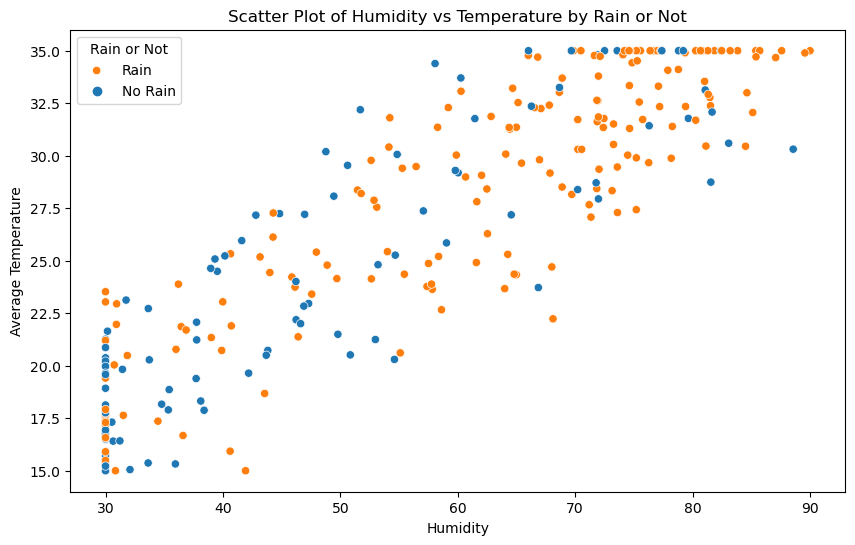

In [27]:
# Scatter plot of humidity vs temperature by rain or not
plt.figure(figsize=(10, 6))
sns.scatterplot(x='humidity', y='avg_temperature', hue='rain_or_not', data=df, palette=['#1f77b4', '#ff7f0e'])
plt.title('Scatter Plot of Humidity vs Temperature by Rain or Not')
plt.xlabel('Humidity')
plt.ylabel('Average Temperature')
plt.legend(title='Rain or Not', labels=['Rain', 'No Rain'])
plt.show()

### 3. Model Training and Evaluation

We split the dataset into training and testing sets and train several machine learning models:
- **Logistic Regression**
- **Random Forest**
- **Gradient Boosting**
- **Support Vector Machine (SVM)**

We then evaluate each model using common metrics (accuracy, precision, recall, F1 score, ROC AUC) and output the classification report.


In [28]:
from sklearn.model_selection import train_test_split

# Feature Engineering
X = df.drop(['rain_or_not'], axis=1)
y = df['rain_or_not']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Initialize the Logistic Regression pipeline
pipeline_lr = Pipeline([
	('scaler', StandardScaler()),
	('classifier', LogisticRegression())
])

pipeline_lr.fit(X_train, y_train)
y_pred_lr = pipeline_lr.predict(X_test)
y_prob_lr = pipeline_lr.predict_proba(X_test)[:, 1] 

accuracy = accuracy_score(y_test, y_pred_lr)
precision = precision_score(y_test, y_pred_lr)
recall = recall_score(y_test, y_pred_lr)
f1 = f1_score(y_test, y_pred_lr)
roc_auc = roc_auc_score(y_test, y_prob_lr)
class_report = classification_report(y_test, y_pred_lr)

print("Logistic Regression Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("\nClassification Report:")
print(class_report)

Logistic Regression Performance:
Accuracy: 0.8333
Precision: 0.8182
Recall: 0.9474
F1 Score: 0.8780
ROC AUC: 0.9163

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.64      0.74        22
           1       0.82      0.95      0.88        38

    accuracy                           0.83        60
   macro avg       0.85      0.79      0.81        60
weighted avg       0.84      0.83      0.83        60



In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier

# Train the Random Forest model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Predict class labels and probabilities
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]  # Probabilities for ROC AUC

# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf)
recall = recall_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf)
roc_auc = roc_auc_score(y_test, y_prob_rf)
class_report = classification_report(y_test, y_pred_rf)

# Display the results
print("Random Forest Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("\nClassification Report:")
print(class_report)

Random Forest Performance:
Accuracy: 0.7000
Precision: 0.7000
Recall: 0.9211
F1 Score: 0.7955
ROC AUC: 0.7883

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.32      0.44        22
           1       0.70      0.92      0.80        38

    accuracy                           0.70        60
   macro avg       0.70      0.62      0.62        60
weighted avg       0.70      0.70      0.66        60



In [31]:
# Train the Gradient Boosting model
from sklearn.ensemble import GradientBoostingClassifier


gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)

# Predict class labels and probabilities
y_pred_gb = gb.predict(X_test)
y_prob_gb = gb.predict_proba(X_test)[:, 1]  # Probabilities for ROC AUC

# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred_gb)
precision = precision_score(y_test, y_pred_gb)
recall = recall_score(y_test, y_pred_gb)
f1 = f1_score(y_test, y_pred_gb)
roc_auc = roc_auc_score(y_test, y_prob_gb)
class_report = classification_report(y_test, y_pred_gb)

# Display the results
print("Gradient Boosting Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("\nClassification Report:")
print(class_report)

Gradient Boosting Performance:
Accuracy: 0.7667
Precision: 0.7609
Recall: 0.9211
F1 Score: 0.8333
ROC AUC: 0.8971

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.50      0.61        22
           1       0.76      0.92      0.83        38

    accuracy                           0.77        60
   macro avg       0.77      0.71      0.72        60
weighted avg       0.77      0.77      0.75        60



In [32]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Initialize the SVC with probability=True
pipeline_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC(probability=True, random_state=42))
])

# Fit the model
pipeline_svm.fit(X_train, y_train)

# Predict class labels
y_pred_svm = pipeline_svm.predict(X_test)

# Predict probabilities for ROC AUC
y_prob_svm = pipeline_svm.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred_svm)
precision = precision_score(y_test, y_pred_svm)
recall = recall_score(y_test, y_pred_svm)
f1 = f1_score(y_test, y_pred_svm)
roc_auc = roc_auc_score(y_test, y_prob_svm)
class_report = classification_report(y_test, y_pred_svm)

# Display the results
print("Support Vector Machine Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("\nClassification Report:")
print(class_report)

Support Vector Machine Performance:
Accuracy: 0.7667
Precision: 0.7609
Recall: 0.9211
F1 Score: 0.8333
ROC AUC: 0.8864

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.50      0.61        22
           1       0.76      0.92      0.83        38

    accuracy                           0.77        60
   macro avg       0.77      0.71      0.72        60
weighted avg       0.77      0.77      0.75        60



### 4. Hyperparameter Tuning and Final Model Selection

We use GridSearchCV to perform hyperparameter tuning on the Gradient Boosting classifier. The best model is then evaluated and saved for future predictions.

In [33]:
from sklearn.model_selection import GridSearchCV


param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'subsample': [0.8, 1.0],
    'max_features': ['sqrt', None]
}

grid_search = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1  # Use all CPU cores for parallel computation
)
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 1.0}


In [34]:
from sklearn.metrics import roc_auc_score


best_model = grid_search.best_estimator_
y_proba = best_model.predict_proba(X_test)[:, 1]  
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))

ROC-AUC Score: 0.9198564593301435


### 5. Rain Prediction

The trained model is used to predict the probabilities of rain for the test dataset. The predicted probabilities are then compared with the actual values to evaluate the model's performance.


In [35]:
# Predict Rain Probability
best_model = grid_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
df_test_results = pd.DataFrame({'Actual': y_test, 'Predicted Probability (%)': y_pred_proba.round(4) * 100})
print(df_test_results.head(20))

     Actual  Predicted Probability (%)
215       1                      88.98
254       0                      19.48
32        0                      66.65
88        0                      42.51
242       0                      43.32
200       0                      49.62
149       1                      92.20
248       0                      28.46
122       1                      71.25
281       0                      56.12
92        1                      70.02
198       1                      63.42
261       1                      93.12
31        1                      92.50
197       1                      44.22
38        1                      89.25
232       1                      92.18
93        1                      88.57
40        1                      93.12
4         1                      92.45


In [36]:
import joblib

joblib.dump(best_model, 'rain_prediction_model.pkl')


['rain_prediction_model.pkl']